Satellite Image Segmentation -Pytorch

# Train the model


In [1]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import seaborn as sns
import math
import torch
from torch.utils.data.dataset import Dataset
import segmentation_models_pytorch as smp
import rasterio
from torch.utils.data import DataLoader

In [2]:

IMGS_DIR = "C:/Users/Deepali Thakur/OneDrive - University of Suffolk/Desktop/DEEPLEARNING/images"
MASKS_DIR = "C:/Users/Deepali Thakur/OneDrive - University of Suffolk/Desktop/DEEPLEARNING/masks"
IMG_CHIPS_DIR = "C:/Users/Deepali Thakur/Landcover/chips/img"
MSK_CHIPS_DIR = "C:/Users/Deepali Thakur/Landcover/chips/msk"
TARGET_SIZE = 512


In [3]:
os.chdir("C:/users/Deepali Thakur/Landcover")
img_paths = glob.glob(os.path.join(IMGS_DIR, "*.tif"))
mask_paths = glob.glob(os.path.join(MASKS_DIR, "*.tif"))
img_paths.sort()
mask_paths.sort()

In [ ]:
os.makedirs(IMG_CHIPS_DIR)
os.makedirs(MSK_CHIPS_DIR)
for i, (img_path, mask_path) in enumerate(zip(img_paths, mask_paths)):
    img_filename = os.path.splitext(os.path.basename(img_path))[0]
    mask_filename = os.path.splitext(os.path.basename(mask_path))[0]
    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path)

    assert img_filename == mask_filename and img.shape[:2] == mask.shape[:2]

    k = 0
    for y in range(0, img.shape[0], TARGET_SIZE):
        for x in range(0, img.shape[1], TARGET_SIZE):
            img_tile = img[y:y + TARGET_SIZE, x:x + TARGET_SIZE]
            mask_tile = mask[y:y + TARGET_SIZE, x:x + TARGET_SIZE]

            if img_tile.shape[0] == TARGET_SIZE and img_tile.shape[1] == TARGET_SIZE:
                out_img_path = os.path.join(IMG_CHIPS_DIR, "{}_{}.PNG".format(img_filename, k))
                cv2.imwrite(out_img_path, img_tile)

                out_mask_path = os.path.join(MSK_CHIPS_DIR, "{}_{}.PNG".format(mask_filename, k))
                cv2.imwrite(out_mask_path, mask_tile)

            k += 1

    print("Processed {} {}/{}".format(img_filename, i + 1, len(img_paths)))

In [4]:
train_img_dir = "C:/Users/Deepali Thakur/Landcover/chips/img/"
train_mask_dir = "C:/Users/Deepali Thakur/Landcover/chips/msk/"
img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

In [5]:
num_images = len(os.listdir(train_img_dir))

In [6]:
import random
img_num = random.randint(0, num_images-1)

In [7]:
img_for_plot = cv2.imread(train_img_dir+img_list[img_num], 1)
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)
img_for_plot.shape

(512, 512, 3)

In [8]:
mask_for_plot =cv2.imread(train_mask_dir+msk_list[img_num], 0)
mask_for_plot.shape

(512, 512)

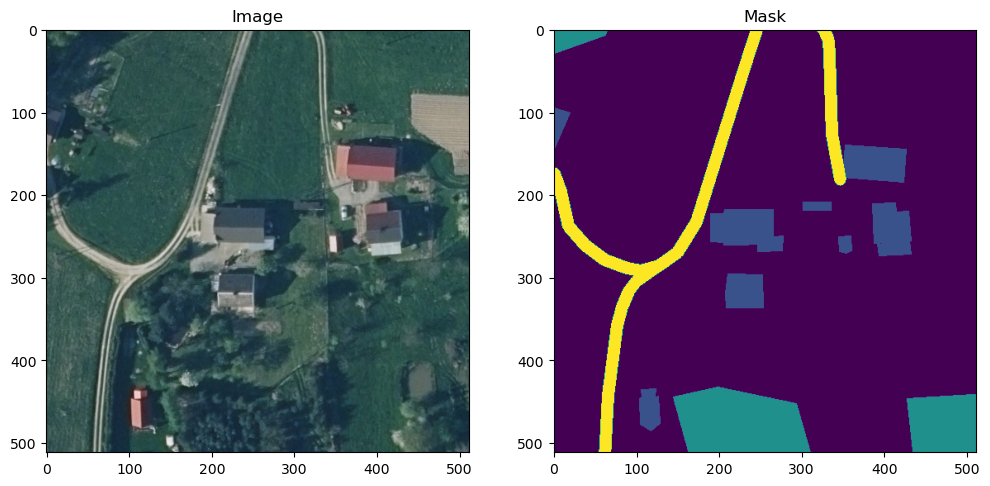

In [9]:
plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot)
plt.title('Mask')
plt.show()

In [ ]:
os.makedirs('C:/Users/Deepali Thakur/Landcover/images/')
os.makedirs('C:/Users/Deepali Thakur/Landcover/masks/')
useless=0  #Useless image counter
for img in range(len(img_list)):   #Using t1_list as all lists are of same size
    img_name=img_list[img]
    mask_name = msk_list[img]
    print("Now preparing image and masks number: ", img)
      
    temp_image=cv2.imread(train_img_dir+img_list[img], 1)
   
    temp_mask=cv2.imread(train_mask_dir+msk_list[img], 0)
    #temp_mask=temp_mask.astype(np.uint8)
    
    val, counts = np.unique(temp_mask, return_counts=True)
    
    if (1 - (counts[0]/counts.sum())) > 0.05:  #At least 5% useful area with labels that are not 0
        print("Save Me")
        cv2.imwrite('C:/Users/Deepali Thakur/Landcover/images/'+img_name, temp_image)
        cv2.imwrite('C:/Users/Deepali Thakur/Landcover/masks/'+mask_name, temp_mask)
        
    else:
        print("I am useless")   
        useless +=1

print("Total useful images are: ", len(img_list)-useless)  
print("Total useless images are: ", useless) 

In [ ]:
###############################################################
#Now split the data into training, validation and testing. 
import splitfolders 
input_folder = 'C:/Users/Deepali Thakur/Landcover/useful/'
output_folder = 'C:/Users/Deepali Thakur/Landcover/data/'
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.60,.20,.20), group_prefix=None) 


In [ ]:
import os
import csv
import glob

folder_path = "C:/Users/Deepali Thakur/Landcover/data/Val_masks/val/"  # Replace with the actual folder path

# Get all PNG files in the folder
#png_files = [file for file in os.listdir(folder_path) if file.endswith(".png")]
png_files = (glob.glob('C:/Users/Deepali Thakur/Landcover/data/Val_masks/val/*.png'))

# Write filenames to a CSV file
csv_file_path = "C:/Users/Deepali Thakur/Landcover/data4.csv"  # Replace with the desired output file path

try:
    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["File Name"])  # Write the header
        for png_file in png_files:
            writer.writerow([png_file])
    print("Filenames written to CSV file successfully.")
except IOError:
    print("An error occurred while writing to the CSV file.")

In [10]:
from typing import Optional, List
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataset import Dataset
import albumentations as A
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils.metrics

In [11]:
# Change directory
os.chdir("C:/Users/Deepali Thakur/Landcover/data")
train = pd.read_csv('C:/Users/Deepali Thakur/Landcover/data.csv')
test = pd.read_csv ('C:/Users/Deepali Thakur/Landcover/data2.csv')
val = pd.read_csv('C:/Users/Deepali Thakur/Landcover/data3.csv')
#print(train.info())

In [12]:
print(val.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2012 entries, 0 to 2011
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   S.No.      2012 non-null   int64 
 1   name       2012 non-null   object
 2   img_path   2012 non-null   object
 3   mask_path  2012 non-null   object
dtypes: int64(1), object(3)
memory usage: 63.0+ KB
None


In [13]:
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1764 entries, 0 to 1763
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   S.No.      1764 non-null   int64 
 1   name       1764 non-null   object
 2   img_path   1764 non-null   object
 3   mask_path  1764 non-null   object
dtypes: int64(1), object(3)
memory usage: 55.2+ KB
None


In [14]:
#Check if GPU is available ===================================
avail = torch.cuda.is_available()
devCnt = torch.cuda.device_count()
devName = torch.cuda.get_device_name(0)
print("Available: " + str(avail) + ", Count: " + str(devCnt) + ", Name: " + str(devName))

Available: True, Count: 1, Name: NVIDIA GeForce GTX 1650


In [15]:
# Define Variables ========================================
MULTICLASS_MODE: str = "multiclass"
ENCODER = "resnet18"
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['background', 'building', 'woodlands', 'water','Road']
ACTIVATION = None
DEVICE = 'cuda'


In [16]:
 #Subclass and define custom dataset ===========================
class MultiClassSegDataset(Dataset):
    
    def __init__(self, df, classes=None, transform=None,):
        self.df = df
        self.classes = classes
        self.transform = transform
    
    def __getitem__(self, idx):
        
        image_name = self.df.iloc[idx, 2]
        mask_name = self.df.iloc[idx, 3]
        image = cv2.imread(image_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_name, cv2.IMREAD_UNCHANGED)
        image = image.astype('uint8')
        #mask = mask[:,:,0]
        #mask = np.expand_dims(mask, axis=2)
        if(self.transform is not None):
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
            image = torch.from_numpy(image)
            mask = torch.from_numpy(mask)   
            image = image.permute(2, 0, 1)
            image = image.float()/255
            mask = mask.long().unsqueeze(0)
        else: 
            image = torch.from_numpy(image)
            mask = torch.from_numpy(mask)
            image = image.permute(2, 0, 1)
            image = image.float()/255
            mask = mask.long().unsqueeze(0)
        return image, mask  
        
    def __len__(self):
        return len(self.df)


In [17]:
#Define tranforms using Albumations =======================================
test_transform = A.Compose(
    [A.PadIfNeeded(min_height=512, min_width=512, border_mode=4), A.Resize(512, 512),]
)

train_transform = A.Compose(
    [
        A.PadIfNeeded(min_height=512, min_width=512, border_mode=4),
        A.Resize(512, 512),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.MedianBlur(blur_limit=3, always_apply=False, p=0.1),
    ]
)


In [18]:
# Create the datasets   ================================================ 
trainDS = MultiClassSegDataset(train, classes=CLASSES, transform=train_transform)
testDS = MultiClassSegDataset(test, classes=CLASSES, transform=test_transform)
valDS = MultiClassSegDataset(val, classes=CLASSES, transform=test_transform)
print("Number of Training Samples: " + str(len(train)) + " Number of Validation Samples: " + str(len(val))
      + " Number of Test Samples: " + str(len(test)))


Number of Training Samples: 5289 Number of Validation Samples: 2012 Number of Test Samples: 1764


In [19]:
# Define DataLoaders ==============================================
trainDL = torch.utils.data.DataLoader(trainDS, batch_size=3, shuffle=True, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)
testDL =  torch.utils.data.DataLoader(testDS, batch_size=3, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)
valDL =  torch.utils.data.DataLoader(valDS, batch_size=3, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)



In [20]:
# Check Tensor shapes ======================================================
batch = next(iter(trainDL))
images, labels = batch
print(images.shape, labels.shape, type(images), type(labels), images.dtype, labels.dtype)

torch.Size([3, 3, 512, 512]) torch.Size([3, 1, 512, 512]) <class 'torch.Tensor'> <class 'torch.Tensor'> torch.float32 torch.int64


In [21]:
# Check first sample from patch =================================================
testImg = images[1]
testMsk = labels[1]
print(testImg.shape, testImg.dtype, type(testImg), testMsk.shape, 
testMsk.dtype, type(testMsk), testImg.min(), 
testImg.max(), testMsk.min(), testMsk.max())

torch.Size([3, 512, 512]) torch.float32 <class 'torch.Tensor'> torch.Size([1, 512, 512]) torch.int64 <class 'torch.Tensor'> tensor(0.1922) tensor(0.8667) tensor(0) tensor(3)


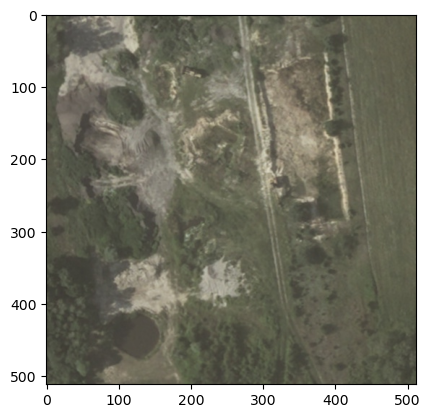

In [22]:
# Plot example image =====================================
plt.imshow(testImg.permute(1,2,0))
plt.show()

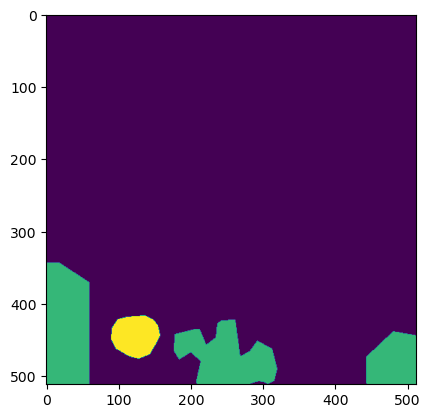

In [23]:
# Plot exmaple mask ======================================
plt.imshow(testMsk.permute(1,2,0))
plt.show()

In [24]:
# Initiate UNet++ Model ======================================
model = smp.UnetPlusPlus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    in_channels=3,
    classes=5,
    activation=ACTIVATION,
    )

In [25]:
#Define Loss and Metrics to Monitor ======================================
loss = smp.losses.DiceLoss(mode="multiclass")
loss.__name__ = 'Dice_loss'
metrics = [
    smp.utils.metrics.Fscore(),
    smp.utils.metrics.Accuracy(),
    smp.utils.metrics.Recall(),
    smp.utils.metrics.Precision(),
    smp.utils.metrics.IoU(),
    
]

In [26]:
# Define Optimizer (Adam in this case) and learning rate ============================
optimizer = optim.Adam(params=model.parameters(), lr=0.001)

In [27]:
# Define training epoch =====================================
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss,
    metrics= metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

In [28]:
# Define testing epoch =====================================
val_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [ ]:
# Train the Model===========================================
train_losses = []
val_losses = []

for epoch in range(25):
    train_logs = train_epoch.run(trainDL)
    val_logs = val_epoch.run(valDL)
    
    # Retrieve the training and validation losses from the logs
    train_loss = train_logs['Dice_loss']
    val_loss = val_logs['Dice_loss']
    
    # Append the losses to the respective lists
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Save the model's state dictionary based on the validation loss
    if epoch == 0 or val_loss < min(val_losses[:-1]):
        torch.save(model, './best_model4.pth')
        
 # Load saved model =============================================
best_model4 = torch.load('./best_model4.pth')


# Plot the training and validation losses
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(range(1, 25), train_losses, label='Training Loss')
plt.plot(range(1, 25), val_losses, label='Validation Loss')
plt.legend()
plt.show()


In [31]:
import gc
def report_gpu():
   print(torch.cuda.list_gpu_processes())
   gc.collect()
   torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  543609 KB |    1514 MB |  150835 MB |  150304 MB |\n|       from large pool |  536960 KB |    1508 MB |  149585 MB |  149060 MB |\n|       from small pool |    6649 KB |       7 MB |    1250 MB |    1243 MB |\n|---------------------------------------------------------------------------|\n| Active memory         |  543609 KB |    1514 MB |  150835 MB |  150304 MB |\n|       from large pool |  536960 KB |    1508 MB |

In [29]:
# Load saved model =============================================
best_model4 = torch.load('./best_model4.pth')

# Evaluate model on Test set==============================

test_epoch = smp.utils.train.ValidEpoch(
    model=best_model4,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(testDL)
print(logs)


valid: 100%|█| 588/588 [02:30<00:00,  3.90it/s, Dice_loss - 0.1779, fscore - 1.012, accuracy - 2.015, recall - 1.064, p
{'Dice_loss': 0.1779288560901229, 'fscore': 1.012432869295685, 'accuracy': 2.015086187477394, 'recall': 1.0637324107747503, 'precision': 1.0935058921170075, 'iou_score': 1.1881569933881164}


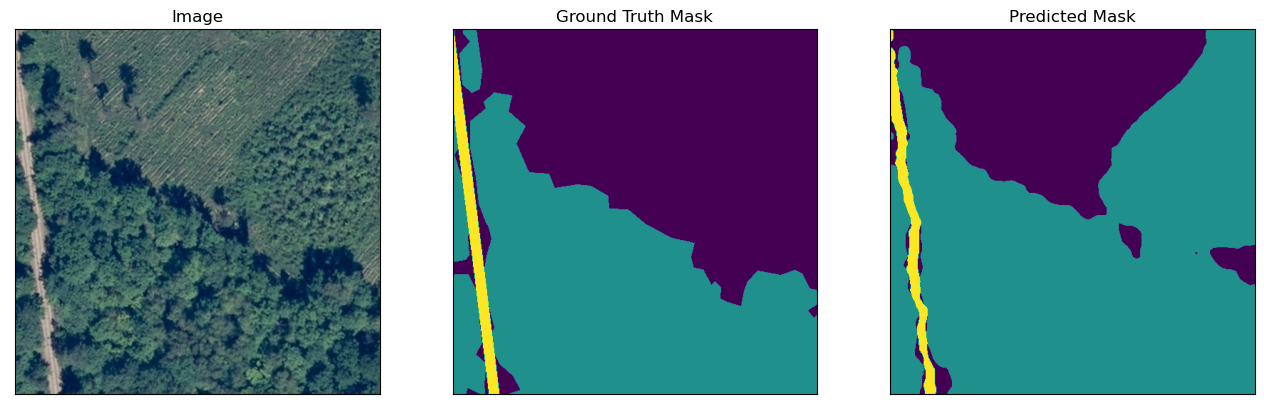

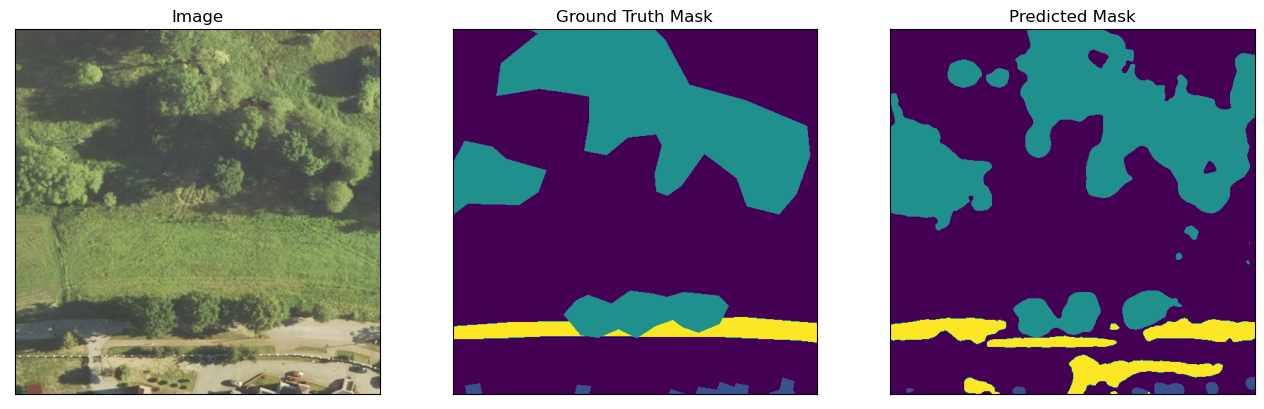

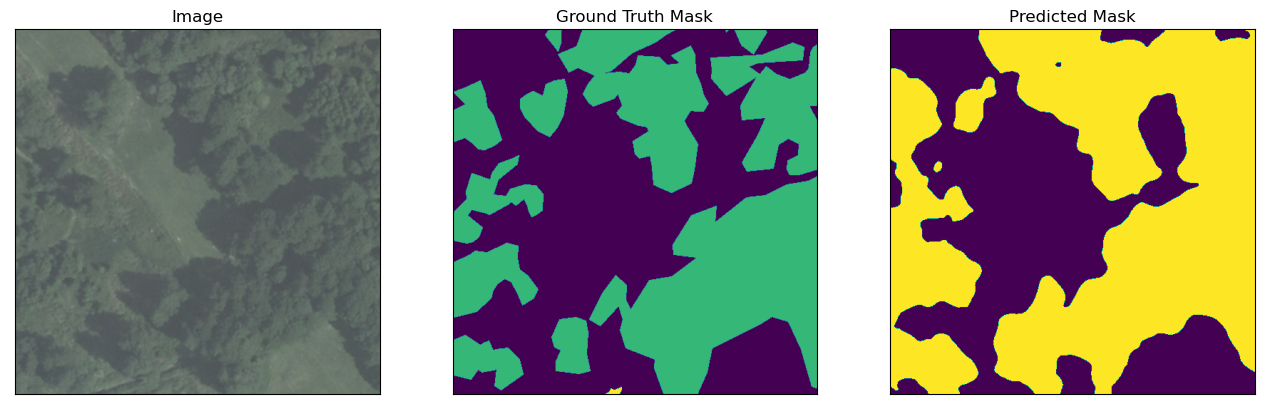

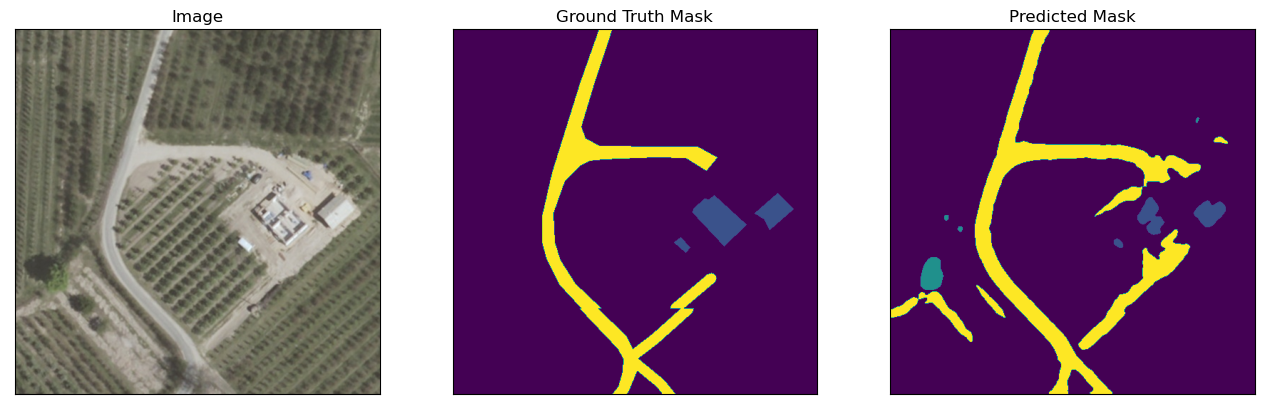

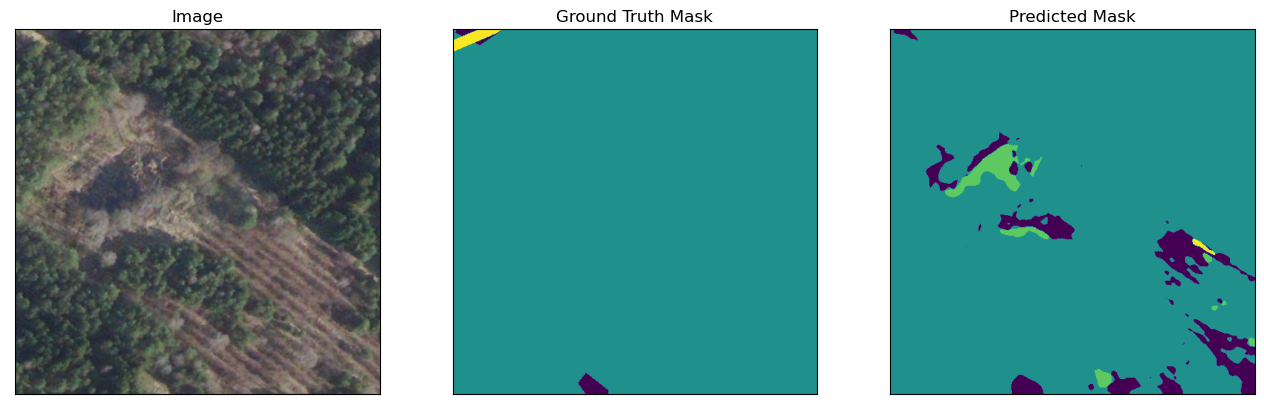

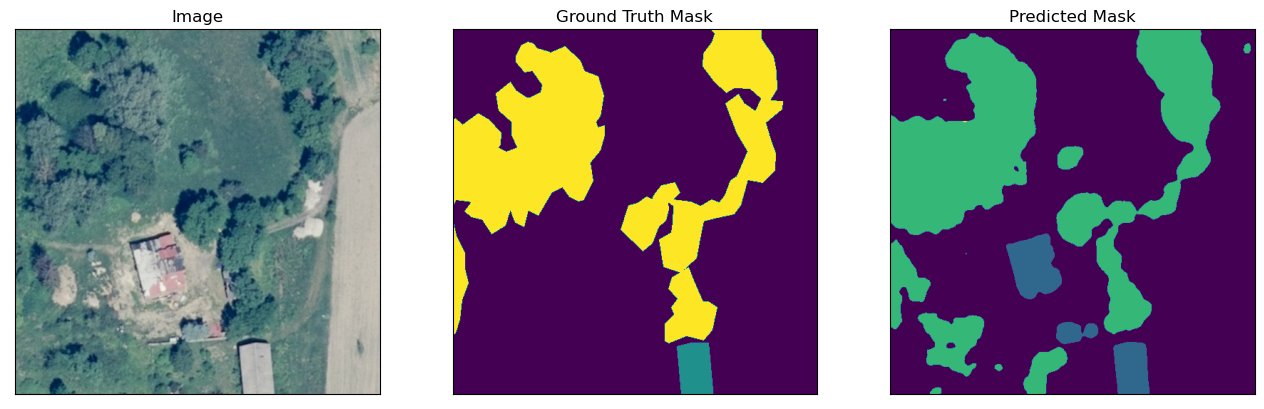

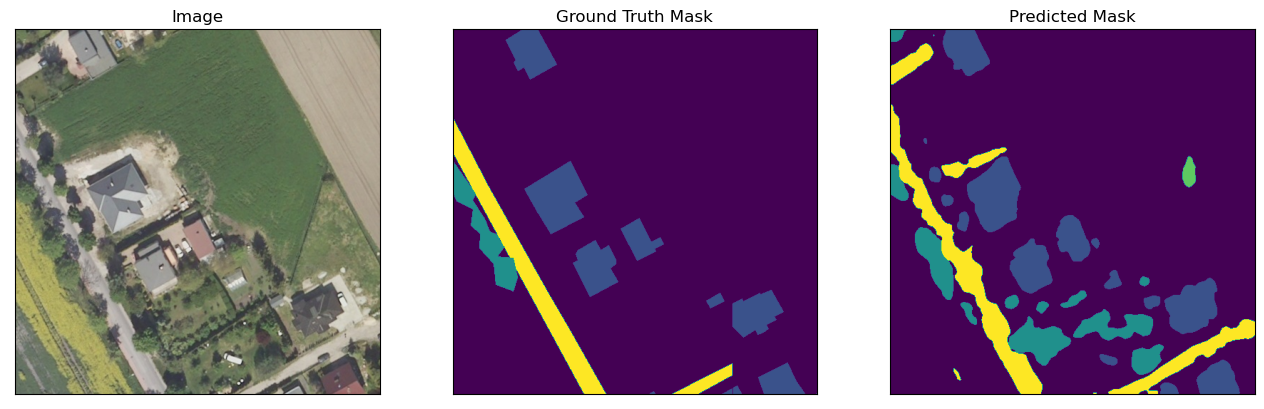

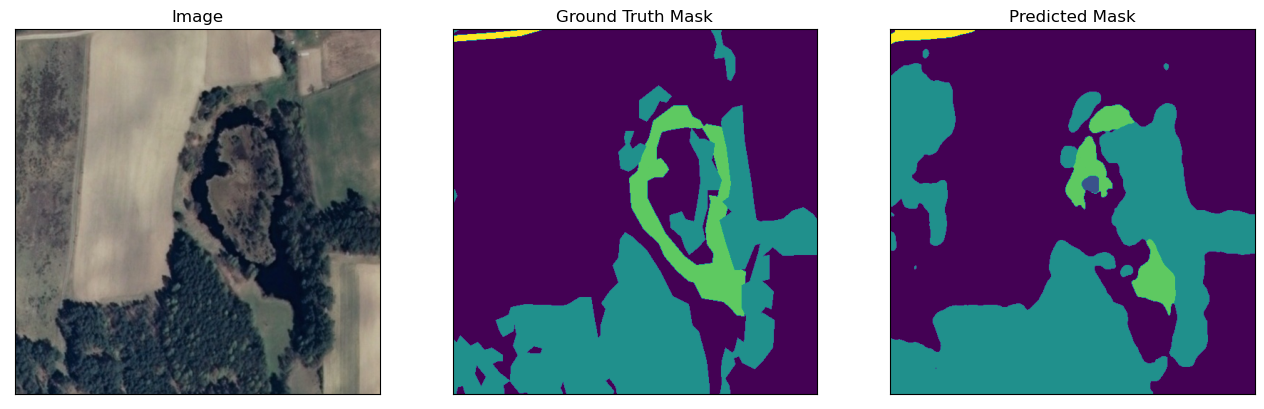

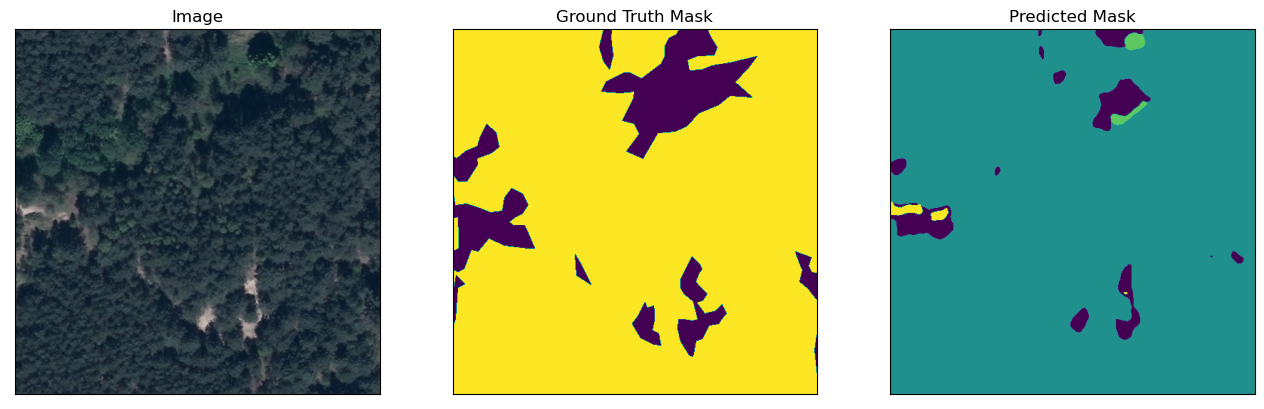

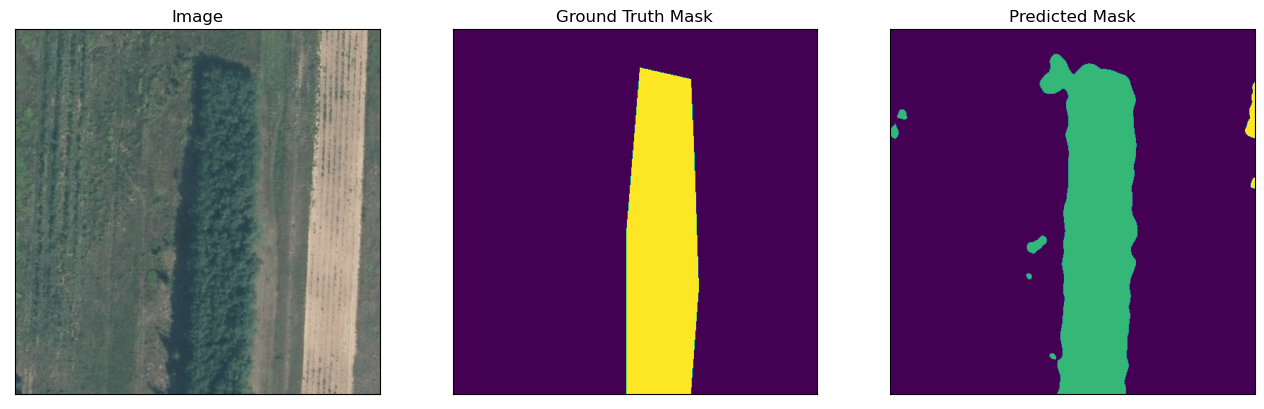

In [13]:
# Load saved model =============================================
best_model4 = torch.load('./best_model4.pth')
# Load saved model =============================================
best_model5 = torch.load('./best_model5.pth')

#Visualize images, masks, and predictions=======================================
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 10))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

for i in range(10):
    n = np.random.choice(len(testDS))
    
    image_vis = testDS[n][0].permute(1,2,0)
    image_vis = image_vis.numpy()*255
    image_vis = image_vis.astype('uint8')
    image, gt_mask =testDS[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = image.to(DEVICE).unsqueeze(0)
    pr_mask = best_model4.predict(x_tensor)
    m = nn.Softmax(dim=1)
    pr_probs = m(pr_mask)              
    pr_mask = torch.argmax(pr_probs, dim=1).squeeze(1)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis,
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )

In [18]:
# Initiate DeepLabv3+ Model ======================================
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    in_channels=3,
    classes=5,
    activation=ACTIVATION,
)


In [ ]:
train_losses = []
val_losses = []

for epoch in range(25):
    train_logs = train_epoch.run(trainDL)
    val_logs = val_epoch.run(valDL)
    
       
    # Retrieve the training and validation losses from the logs
    train_loss = train_logs['Dice_loss']
    val_loss = val_logs['Dice_loss']
    
    # Append the losses to the respective lists
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Save the model's state dictionary based on the validation loss
    if epoch == 0 or val_loss < min(val_losses[:-1]):
        torch.save(model, './best_model5.pth')
        
 # Load saved model =============================================
best_model5 = torch.load('./best_model5.pth')


# Plot the training and validation losses
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(range(1, 26), train_losses, label='Training Loss')
plt.plot(range(1, 26), val_losses, label='Validation Loss')
plt.legend()
plt.show()

In [30]:
# Load saved model =============================================
best_model5 = torch.load('./best_model5.pth')
# Evaluate model on Test set==============================

test_epoch = smp.utils.train.ValidEpoch(
    model=best_model5,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(testDL)
print(logs)

valid: 100%|█| 588/588 [00:59<00:00,  9.94it/s, Dice_loss - 0.1938, fscore - 1.168, accuracy - 1.855, recall - 1.447, p
{'Dice_loss': 0.19378120305814922, 'fscore': 1.1679494614605193, 'accuracy': 1.8550303777589503, 'recall': 1.4470156136215937, 'precision': 1.0968727494532955, 'iou_score': 1.9512296889458807}


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Load saved model
best_model4 = torch.load('./best_model4.pth')

# Define the list of class labels excluding the "background" class
class_labels = CLASSES[1:]

# Define variables for IoU calculation
intersection_sum = 0
union_sum = 0

# Obtain the predicted labels and ground truth labels
y_true = []
y_pred = []

# Iterate over the test data loader to get predictions and true labels
for images, masks in testDL:
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)
    
    # Forward pass to obtain predictions
    outputs = best_model4(images)
    predictions = torch.argmax(outputs, dim=1)
    
    # Convert predictions and masks to numpy arrays
    predictions = predictions.detach().cpu().numpy()
    masks = masks.detach().cpu().numpy()
    
    # Reshape predictions and masks to match each other
    predictions = predictions.reshape(-1)
    masks = masks.reshape(-1)
    
    # Remove the "background" class from predictions and masks
    predictions = predictions[masks != 0]
    masks = masks[masks != 0]
    
    # Append predictions and true labels to the lists
    y_pred.extend(predictions)
    y_true.extend(masks)
    
    # Calculate intersection and union for IoU calculation
    intersection = np.logical_and(predictions, masks).sum()
    union = np.logical_or(predictions, masks).sum()
    
    intersection_sum += intersection
    union_sum += union

# Calculate mean IoU
mean_iou = intersection_sum / union_sum

# Calculate the classification report
report = classification_report(y_true, y_pred, labels=range(1, len(class_labels)+1), target_names=class_labels)

# Print the class-wise evaluation report and mean IoU
print(report)
print('Mean IoU:', mean_iou)


In [21]:
from sklearn.metrics import classification_report
import numpy as np

# Load saved model
best_model5 = torch.load('./best_model5.pth')

# Define the list of class labels excluding the "background" class
class_labels = CLASSES[1:]

# Define variables for IoU calculation
intersection_sum = 0
union_sum = 0

# Obtain the predicted labels and ground truth labels
y_true = []
y_pred = []

# Iterate over the test data loader to get predictions and true labels
for images, masks in testDL:
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)
    
    # Forward pass to obtain predictions
    outputs = best_model5(images)
    predictions = torch.argmax(outputs, dim=1)
    
    # Convert predictions and masks to numpy arrays
    predictions = predictions.detach().cpu().numpy()
    masks = masks.detach().cpu().numpy()
    
    # Reshape predictions and masks to match each other
    predictions = predictions.reshape(-1)
    masks = masks.reshape(-1)
    
    # Remove the "background" class from predictions and masks
    predictions = predictions[masks != 0]
    masks = masks[masks != 0]
    
    # Append predictions and true labels to the lists
    y_pred.extend(predictions)
    y_true.extend(masks)
    
    # Calculate intersection and union for IoU calculation
    intersection = np.logical_and(predictions, masks).sum()
    union = np.logical_or(predictions, masks).sum()
    
    intersection_sum += intersection
    union_sum += union

# Calculate mean IoU
mean_iou = intersection_sum / union_sum

# Calculate the classification report
report = classification_report(y_true, y_pred, labels=range(1, len(class_labels)+1), target_names=class_labels)

# Print the class-wise evaluation report and mean IoU
print(report)
print('Mean IoU:', mean_iou)


              precision    recall  f1-score   support

    building       0.98      0.71      0.82    823376
   woodlands       0.99      0.90      0.94  59481882
       water       0.98      0.86      0.92  12170509
        Road       0.94      0.53      0.68   2395127

   micro avg       0.98      0.88      0.93  74870894
   macro avg       0.97      0.75      0.84  74870894
weighted avg       0.98      0.88      0.93  74870894

Mean IoU: 0.8943256240535875
